# Assignment 1 Getting Started with PyTorch

## Part 1 - Load & Visualize MNIST Dataset

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt

In [2]:
# Load built-in dataset
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:02<00:00, 10330783.85it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 180713.22it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:10<00:00, 436870.54it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 3513796.09it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



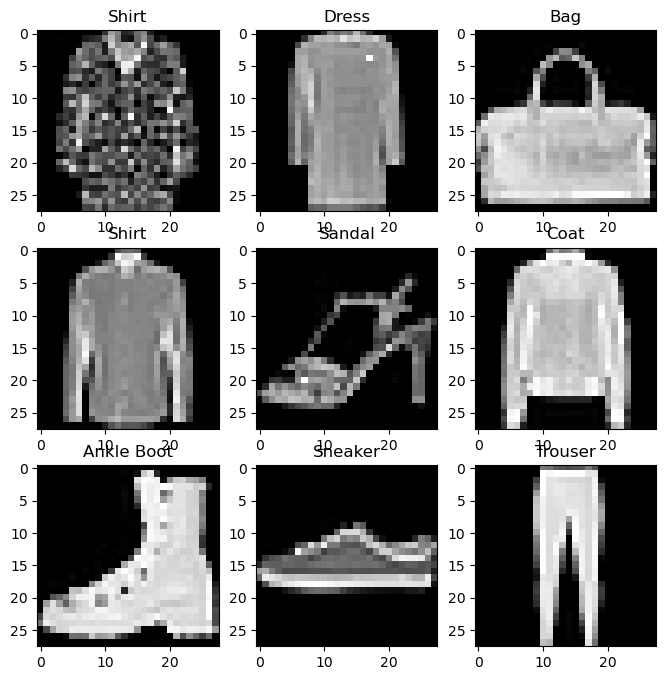

In [7]:
# Set labels
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
fig = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Part 2 - Custom CIFAR100 Dataset Class

In [79]:
import os
import pickle
import numpy as np
from PIL import Image
from torchvision.io import read_image
from torch.utils.data import DataLoader

In [73]:
# Download CIFAR10 data
import torchvision
torchvision.datasets.CIFAR100(root="./data", train=True, download=True)
torchvision.datasets.CIFAR100(root="./data", train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR100
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [91]:
# Define dataset class
class CustomImageDataset(Dataset):
    """
    Custom class to wrap around CIFAR100 dataset.
    """
    def __init__(self, data_path, train=True, transform=None, target_transform=None):
        """
        Init function for the class
        """
        self.transform = transform
        self.target_transform = target_transform

        batch_files = ["train"] if train else ["test"]
        self.data, self.labels = [], []

         # Load the batch file(s)
        for batch in batch_files:
            with open(os.path.join(data_path, "cifar-100-python", f"{batch}"), "rb") as f:
                batch_dict = pickle.load(f, encoding="bytes")
                self.data.append(batch_dict[b"data"])  # Image data (flattened)
                self.labels.extend(batch_dict[b"fine_labels"])  # Fine-grained labels (100 classes)

        # Reshape data to (N, 3, 32, 32)
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)

    def __len__(self):
        """
        Len member function
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Get member function
        """
        image = self.data[idx].transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [107]:
# Init Datasets
train_data = CustomImageDataset("./data/", train=True)
test_data = CustomImageDataset("./data/", train=False)

In [108]:
# Init Dataloaders
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 32, 32, 3])
Labels batch shape: torch.Size([64])


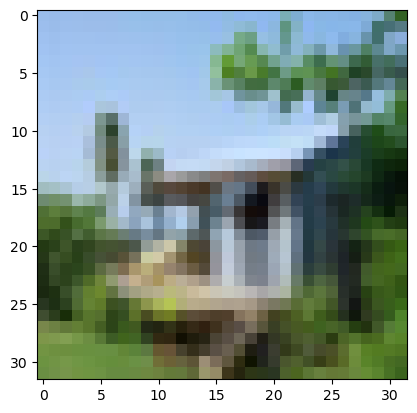

Label: 1


In [123]:
# Check Datasets and Dataloaders are functioning as expected
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
lebel = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Part 3 - Neural Network Class

In [128]:
from torch import nn
import torchvision.transforms as transforms

In [191]:
# Define neural network class
class NeuralNetwork(nn.Module):
    """
    Custom Neural Network class.
    """
    def __init__(self):
        """
        Init function
        """
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(32*32*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 100)
        )

    def forward(self, x):
        """
        Forward function.
        """
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

In [193]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA Available: {torch.cuda.is_available()}")

CUDA Available: False


In [194]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=100, bias=True)
  )
)


## Part 4 - Training & Test Functions

In [195]:
# Define train and test functions
def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Model training loop.
    """
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            # print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    """
    Model test loop.
    """
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)==1).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f"Test Error: \n Accuracy: {100*correct:>1f}%, Avg Loss: {test_loss:>8f}\n")

## Model Training and Evaluation

In [206]:
learning_rate = 0.005
momentum = 0.9
epochs = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate,
                            momentum=momentum,
                            weight_decay=1e-4
                            )

train_data = CustomImageDataset("./data/", train=True, transform=transforms.ToTensor())
test_data = CustomImageDataset("./data/", train=False, transform=transforms.ToTensor())

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

Epoch 1
Test Error: 
 Accuracy: 1.150000%, Avg Loss: 0.050286

Epoch 2
Test Error: 
 Accuracy: 1.190000%, Avg Loss: 0.050214

Epoch 3
Test Error: 
 Accuracy: 1.150000%, Avg Loss: 0.049895

Epoch 4
Test Error: 
 Accuracy: 1.140000%, Avg Loss: 0.049947

Epoch 5
Test Error: 
 Accuracy: 1.160000%, Avg Loss: 0.049849

Epoch 6
Test Error: 
 Accuracy: 1.250000%, Avg Loss: 0.049472

Epoch 7
Test Error: 
 Accuracy: 1.140000%, Avg Loss: 0.049444

Epoch 8
Test Error: 
 Accuracy: 1.150000%, Avg Loss: 0.049334

Epoch 9
Test Error: 
 Accuracy: 1.170000%, Avg Loss: 0.049437

Epoch 10
Test Error: 
 Accuracy: 1.160000%, Avg Loss: 0.049113

Epoch 11
Test Error: 
 Accuracy: 1.130000%, Avg Loss: 0.048873

Epoch 12
Test Error: 
 Accuracy: 1.160000%, Avg Loss: 0.049065

Epoch 13
Test Error: 
 Accuracy: 1.130000%, Avg Loss: 0.048687

Epoch 14
Test Error: 
 Accuracy: 1.150000%, Avg Loss: 0.048567

Epoch 15
Test Error: 
 Accuracy: 1.220000%, Avg Loss: 0.048659

Epoch 16
Test Error: 
 Accuracy: 1.140000%, Avg L